# Lab 8-1: SVD with Monthly Precipitation

Derived from svd_tutorial.m (data decomposition tutorial using SVD in MATLAB)

by Brian Henn, UW, October 2013. Updated by Jessica Lundquist, October 2014. Converted to python by Steven Pestana, November 2019. Updated again by Jessica November 2025.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# we'll use scipy's IO library and datetime to read .mat files
import scipy.io as sio 
import datetime as dt

# SVD function from scipy
from scipy.linalg import svd

---
#### Read in PRISM file

**NOTE: on the JupyterHub the following file is not available, meaning that we'll see a "FileNotFoundError"**

You will need to download this file from the course Canvas page to run this notebook. It can be found under files/Week08

In [2]:
data = sio.loadmat('PRISM_4km_1982-2012.mat')

In [3]:
# Inspect the dictionary keys
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Zs', 'dates', 'xs', 'ys', 'Xs', 'Ys', 'ppt_mean', 'ppt', 'map_index', 'ny', 'nx', 'nm', 'n', 'ppt_stdev'])


Unpack the mat file into numpy arrays, format dates to python datetimes following the method outlined [here](https://sociograph.blogspot.com/2011/04/how-to-avoid-gotcha-when-converting.html).

In [4]:
# convert matlab format dates to python datetimes
datenums = data['dates'][:,0]
dates = [dt.datetime.fromordinal(int(d)) + dt.timedelta(days=int(d)%1) - dt.timedelta(days = 366) for d in datenums]

# Unpack the rest of the data
Zs = data['Zs'] #elevation
xs = data['xs'] # x coordinate
ys = data['ys'] # y coordinate
Xs = data['Xs'] # longitude on a grid
Ys = data['Ys'] # latitude on a grid
ppt_mean = data['ppt_mean'] #mean precipitation in mm
ppt = data['ppt'] #precipitation anomalies in numbers of standard deviations
map_index = data['map_index'][:,0] - 1 # map indices need to be shifted by -1 for numpy arrays
ny = data['ny'][0][0] #size in the y dimension
nx = data['nx'][0][0] # size in the x dimension
nm = data['nm'][0][0]
n = data['n'][0][0]
ppt_stdev = data['ppt_stdev'] #standard deviation in mm

**ppt_mean**: gridded array of average monthly rainfall (mm) (lat. x lon.)

**ppt**: gridded array of monthly rainfall anomaly (unitless, in numbers of standard deviations) (lat. x lon.) (ppt has a mean of 0)

**ppt_stdev**:  gridded array of the standard deviation in monthly rainfall by location (mm)

**map_index**: list of indices for rearranging 1D array into gridded data


I'm also going to define this function, which will help us use the "map_index" to correctly shape our data into 2D maps

In [5]:
def make_map(X, n, nx, ny):
    # create an empty np array full of NaN values, that's the correct length for our 2D data
    a = np.full(n, np.nan)
    # use the map_index to arrange data values from this selected month into array "a"
    a[map_index] = X
    # reshape "a" into a 2D array of the correct shape
    b = a.reshape([nx, ny]).T
    # return our 2D map
    return b

---
#### Plot Elevation Data

Text(0, 0.5, 'latitude')

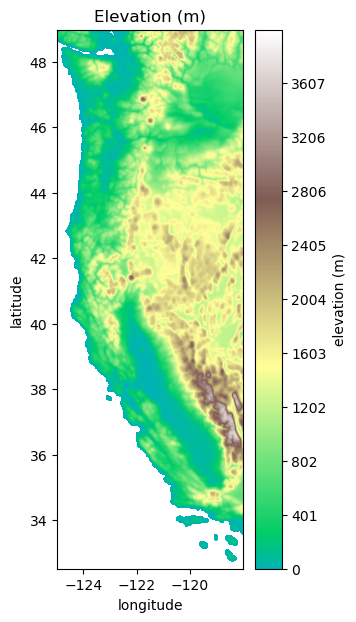

In [6]:
plt.figure(figsize=(3,7))
plt.contourf(Xs,Ys,Zs, levels=np.linspace(0,4000,500), cmap='terrain', vmin=-1000)
cbar=plt.colorbar()
cbar.ax.set_ylabel('elevation (m)')
plt.title('Elevation (m)')
plt.xlabel('longitude')
plt.ylabel('latitude')

---
#### Plot Mean Precip. Data

Text(0, 0.5, 'latitude')

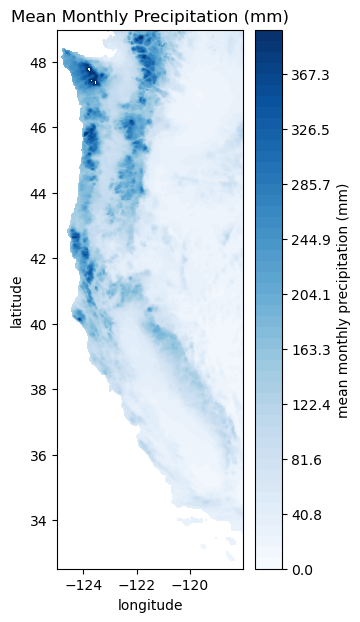

In [7]:
plt.figure(figsize=(3,7))
plt.contourf(Xs,Ys,ppt_mean, levels=np.linspace(0,400), cmap='Blues')
cbar=plt.colorbar()
cbar.ax.set_ylabel('mean monthly precipitation (mm)')
plt.title('Mean Monthly Precipitation (mm)');
plt.xlabel('longitude')
plt.ylabel('latitude')

---
#### Plot some monthly precipitation anomalies

In [8]:
month = 0  #this index tells us which month in our timeseries we want to plot
print(dates[0]) # print our first date (this data is on a monthly timestep, so it will be our first month)

1981-10-01 00:00:00


This first month in our dataset is October 1981

Plot precipitation anomaly for this month (we are using our "make_map" function below to rearrange the precip data into the correct 2D shape)

Text(0, 0.5, 'latitude')

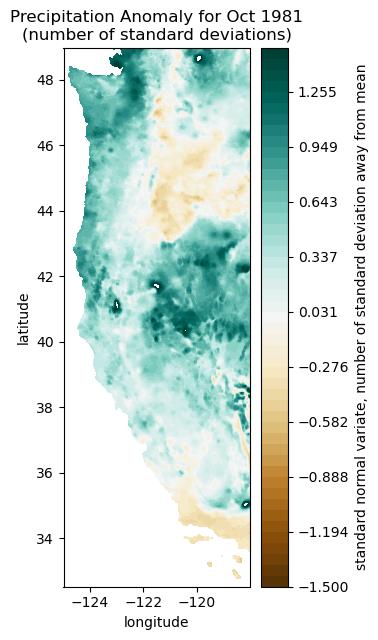

In [9]:
plt.figure(figsize=(3,7))
plt.contourf(Xs, Ys, make_map(ppt[:,month], n, nx, ny), levels=np.linspace(-1.5,1.5), cmap='BrBG')
cbar=plt.colorbar()
cbar.ax.set_ylabel('standard normal variate, number of standard deviation away from mean')
plt.title('Precipitation Anomaly for Oct 1981\n(number of standard deviations)');
plt.xlabel('longitude')
plt.ylabel('latitude')

Let's just take a brief moment to recognize the format of our data.  For each site, we have a value of mean monthly precipitation for each location on the map, a value of the standard deviation in precipitation for each location on the map, and a timeseries for each location of the map of the number of standard deviations away from the mean precipitation was for that given month. This is often called the standard normal variate.

So, considering the above, what was the actual monthly total precipitation in October 1981?

In [10]:
print(ppt_mean.shape)
print(ppt_stdev.shape)
print(ppt[:,month].shape)
print(396*168)
# Note that the sizes need to be compatible to recombine these, and the mean and standard deviation files are already in map format.
# We can use our make_map function to get the month of interest's standard deviations into that shape as well
test=make_map(ppt[:,month], n, nx, ny)
print(test.shape)
actualpptOct1981=ppt_mean + np.multiply(ppt_stdev,test)

(396, 168)
(396, 168)
(46718,)
66528
(396, 168)


Text(0, 0.5, 'latitude')

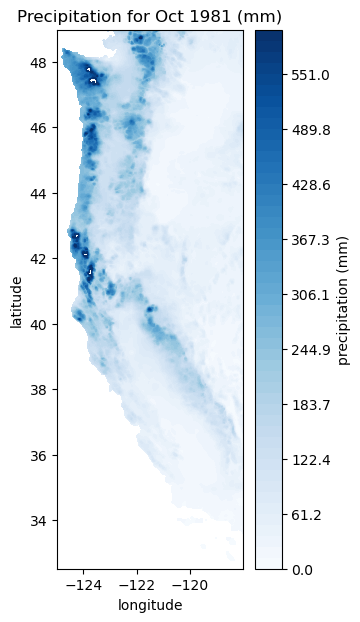

In [11]:
# Now we can make a map of the actual precipitation that month.  Note that we changed the scale bar and the color scheme.
plt.figure(figsize=(3,7))
plt.contourf(Xs, Ys, actualpptOct1981, levels=np.linspace(0,600), cmap='Blues')
cbar=plt.colorbar()
cbar.ax.set_ylabel('precipitation (mm)')
plt.title('Precipitation for Oct 1981 (mm)');
plt.xlabel('longitude')
plt.ylabel('latitude')

## So, why are we breaking up the precipitation data in this way?

It is entirely possible to run an SVD analysis, shown below, on the actual precipitation data.  It is educational to run the analysis on the standard normal variates (with the mean removed and scaled by the standard deviations, as we've done here) as well as on the raw data (without normalizing).  What we have done gives more insight into variations in the data, without having extra emphasis on areas of the domain that both have a lot of precipitation and a lot of variation in that precipitation.  However, it's important when using this code to decide for yourself what is more useful to you.

---
#### Decompose the entire dataset using SVD

In [12]:
U, S, V = svd(ppt,full_matrices=False)

Look at the shape of each the outputs

In [13]:
U.shape, S.shape, V.shape

((46718, 372), (372,), (372, 372))

Note that because we ran svd with "full_matrices=False", it truncates the matrices to the smaller dimension. In this case, the time dimension is much smaller than the space dimension.

**Take a look at the EOFs (U) and PCs (V)**

Text(0, 0.5, 'weight')

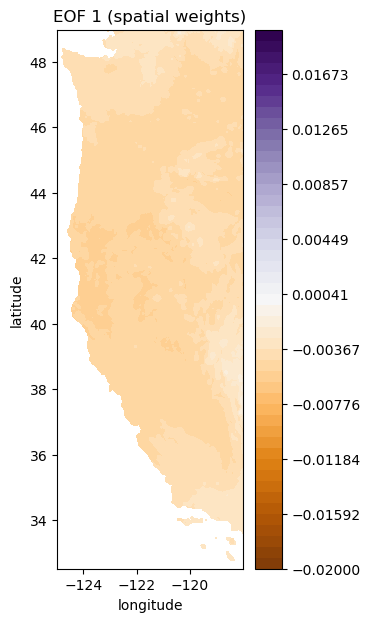

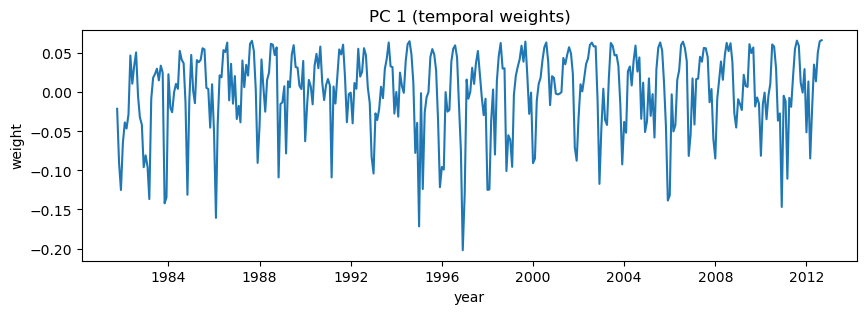

In [14]:
# first index for both U and V
i = 0

# plot first EOF (U)
plt.figure(figsize=(3,7))
plt.contourf(Xs, Ys, make_map(U[:,i], n, nx, ny), levels=np.linspace(-0.02, 0.02), cmap='PuOr')
plt.colorbar()
plt.title('EOF 1 (spatial weights)');
plt.xlabel('longitude')
plt.ylabel('latitude')

# Plot first PC (V)
plt.figure(figsize=(10,3))
plt.plot(dates,V[i,:]);
plt.title('PC 1 (temporal weights)');
plt.xlabel('year')
plt.ylabel('weight')

## Note that you can equivalently plot these each with a -1 multiplier (sometimes that makes it easier to interpret things)
Because each EOF and PC are multiplied together to recreate the original matrix, multiplied _both_ by -1 has no net effect, but in our case, because we are looking at
monthly cycles in precipitation, things make a lot more sense if the the first EOF (which is the same sign across the entire area) has positive spatial weights.
This multiplication may also prove useful on your homework this week.

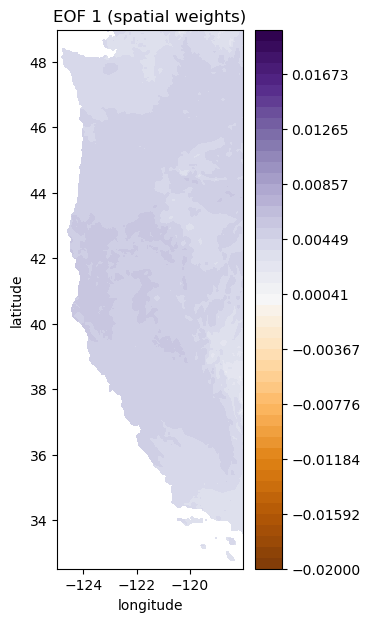

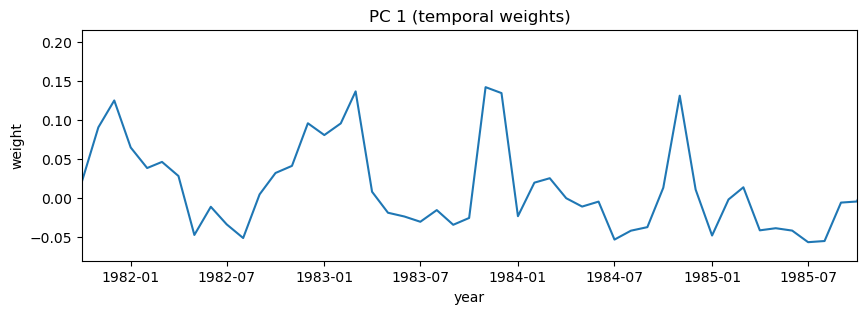

In [15]:
plt.figure(figsize=(3,7))
plt.contourf(Xs,Ys,-1*make_map(U[:,i], n, nx, ny), levels=np.linspace(-0.02, 0.02), cmap='PuOr') # with -1 multiplier
plt.colorbar()
plt.title('EOF 1 (spatial weights)');
plt.xlabel('longitude')
plt.ylabel('latitude')

# Plot first PC
# Note that I'm also going to zoom here so that it's easier to see how things change by month
# over just a few years
i=0
plt.figure(figsize=(10,3))
plt.plot(dates,-1*V[i,:])  # with -1 multiplier
plt.title('PC 1 (temporal weights)')
plt.xlabel('year')
plt.ylabel('weight')
# setting the x limits to the 0th and 48th dates in the dataset
plt.xlim((dates[0], dates[48]));

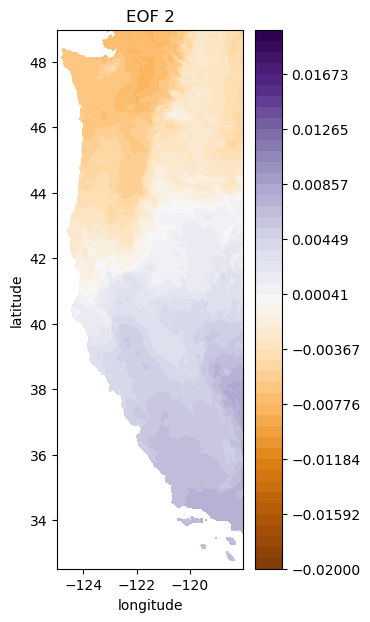

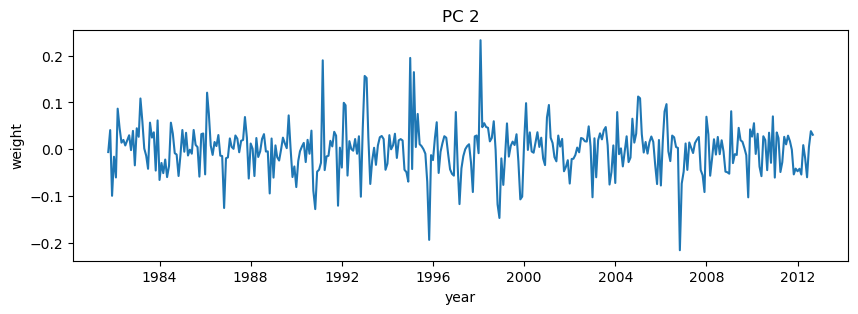

In [16]:
i = 1
# plot second EOF
plt.figure(figsize=(3,7))
plt.contourf(Xs,Ys,-1*make_map(U[:,i], n, nx, ny), levels=np.linspace(-0.02, 0.02), cmap='PuOr')  # with -1 multiplier
plt.colorbar()
plt.title('EOF 2');
plt.xlabel('longitude')
plt.ylabel('latitude')

# Plot second PC
plt.figure(figsize=(10,3))
plt.plot(dates,-1*V[i,:])   # with -1 multiplier
plt.title('PC 2')
plt.xlabel('year')
plt.ylabel('weight');

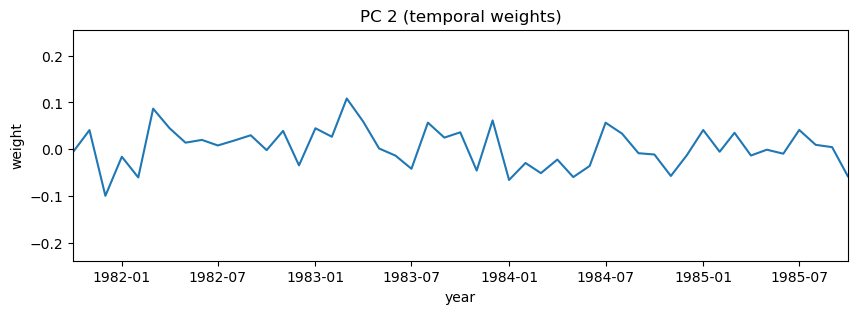

In [17]:
# Again, try zooming in to some specific dates on the PC
i = 1
plt.figure(figsize=(10,3))
plt.plot(dates,-1*V[i,:])  # with -1 multiplier
plt.title('PC 2 (temporal weights)')
plt.xlabel('year')
plt.ylabel('weight')

plt.xlim((dates[0], dates[48]));

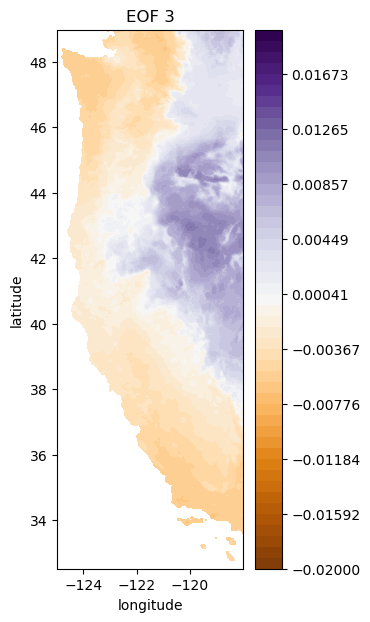

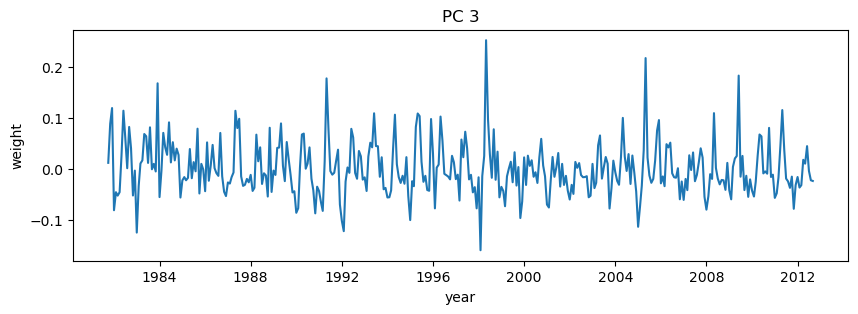

In [18]:
i = 2

# plot third EOF
plt.figure(figsize=(3,7))
plt.contourf(Xs,Ys,-1*make_map(U[:,i], n, nx, ny), levels=np.linspace(-0.02, 0.02), cmap='PuOr')  # with -1 multiplier
plt.colorbar()
plt.title('EOF 3');
plt.xlabel('longitude')
plt.ylabel('latitude')

# Plot third PC
plt.figure(figsize=(10,3))
plt.plot(dates,-1*V[i,:])  # with -1 multiplier
plt.title('PC 3')
plt.xlabel('year')
plt.ylabel('weight');

---
#### SVD Variance Explained
Recall that the values in matrix S are related to the variance explained by each pattern.  The singular values (SV) of a matrix X are defined as the square root of the eigenvalues (EV) of the covariance matrix (X X^T).   To each singular value (from the diagonal matrix) squared refers to the variance explained.

- What fraction of the whole dataset is described by the first 10 patterns?

Compute the fraction of total variance explained by squaring each singular value and dividing by the sum of all variance

In [19]:
# SVD Variance Explained, divide S^2 values by the sum of all S^2
var_exp = S**2 / np.sum(S**2)

Plot our fraction of variance explained versus EOF number

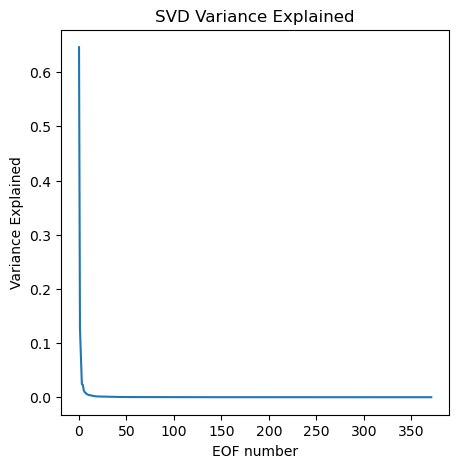

In [20]:
plt.figure(figsize=(5,5))
plt.plot(var_exp)
plt.xlabel('EOF number')
plt.ylabel('Variance Explained')
plt.title('SVD Variance Explained');

Set smaller ranges of axes limits to zoom in to the first 10 EOFs

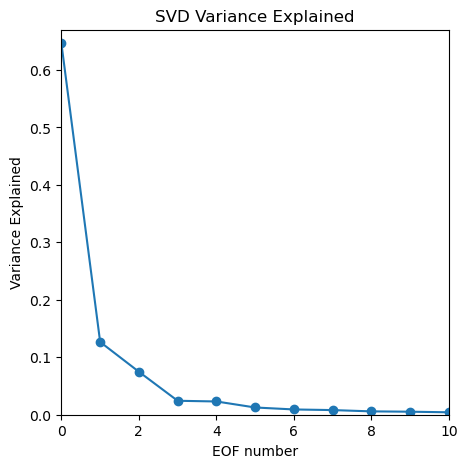

In [29]:
plt.figure(figsize=(5,5))
plt.plot(var_exp,'-o')
plt.xlabel('EOF number')
plt.ylabel('Variance Explained')
plt.title('SVD Variance Explained')
plt.ylim([0,0.67])
plt.xlim([0,10]);

- What fraction of the whole dataset is described by the first 10 patterns?

In [22]:
# the first 10:
print(var_exp[0:10])

# sum of the first 10
print('Percent of overall variance expplained by the top 10 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:10]),1)))

[0.64610997 0.12660152 0.07474693 0.02427751 0.02306013 0.01259243
 0.00917174 0.00807408 0.00582699 0.0052463 ]
Percent of overall variance expplained by the top 10 patterns = 93.6%


---
#### Plot 10 leading EOFs
Note that because they are all plotted in close proximity, we will not put on all the axes labels.
In general, please always remember axes labels.

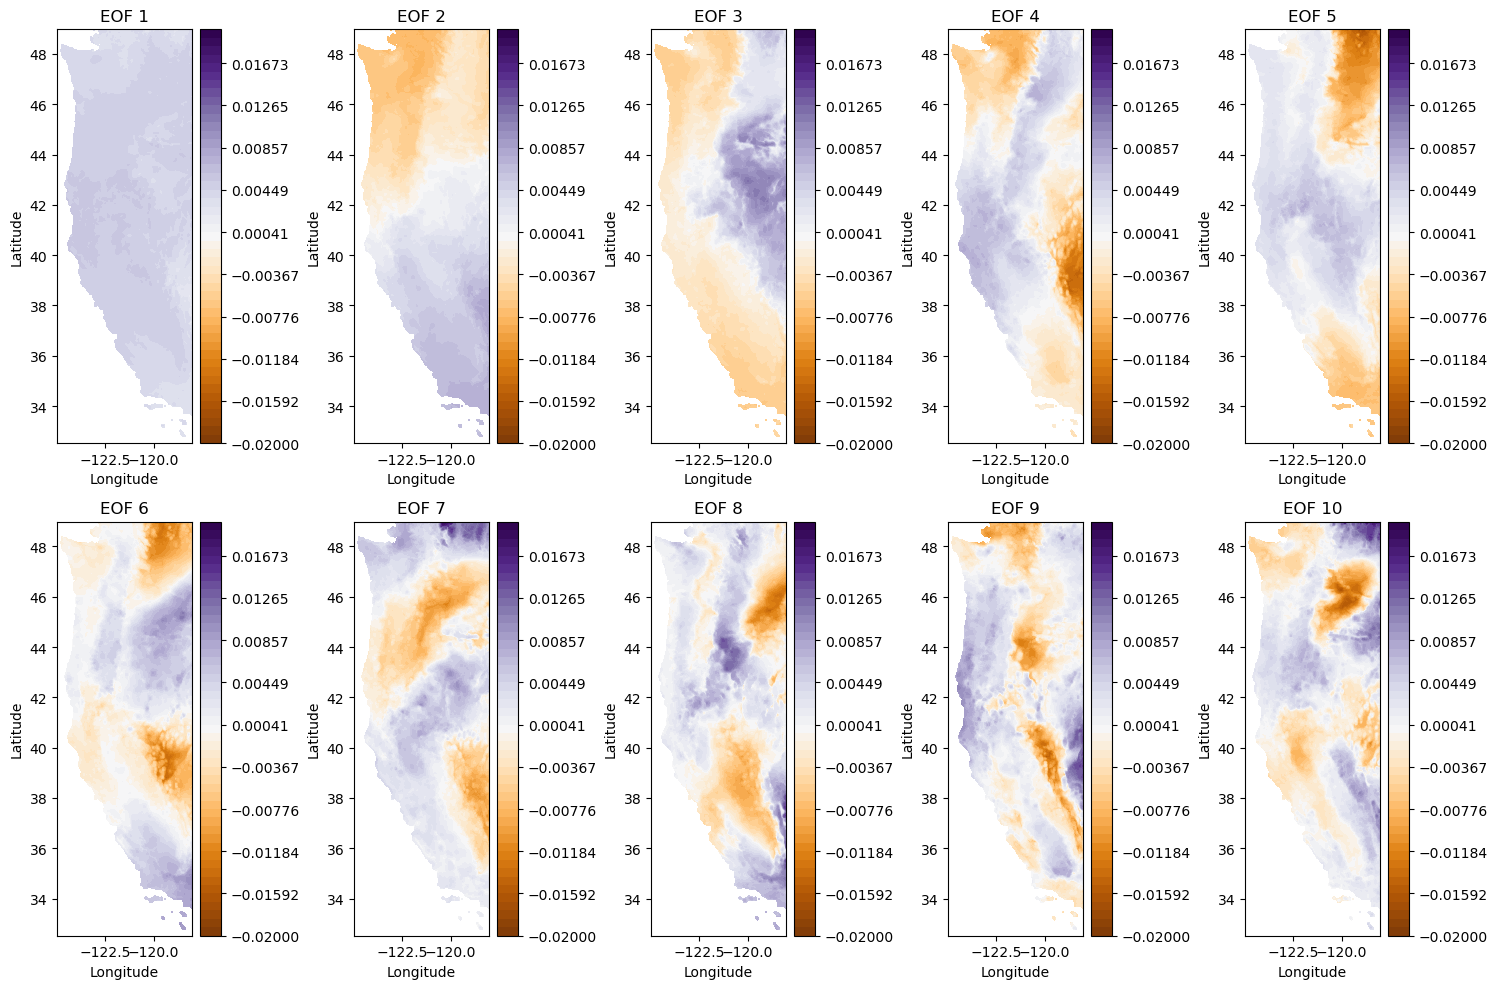

In [23]:
f, ax = plt.subplots(2,5,figsize=(15,10), tight_layout=True)
i = 0
for row in range(2):
    for column in range(5):    
      
        cf = ax[row,column].contourf(Xs,Ys,-1*make_map(U[:,i], n, nx, ny), levels=np.linspace(-0.02, 0.02), cmap='PuOr') # with -1 multiplier
        cbar = plt.colorbar(cf, ax=ax[row,column])
        ax[row,column].set_title('EOF {}'.format(i+1))
        ax[row,column].set_xlabel('Longitude')
        ax[row,column].set_ylabel('Latitude')
        i+=1

plt.tight_layout()

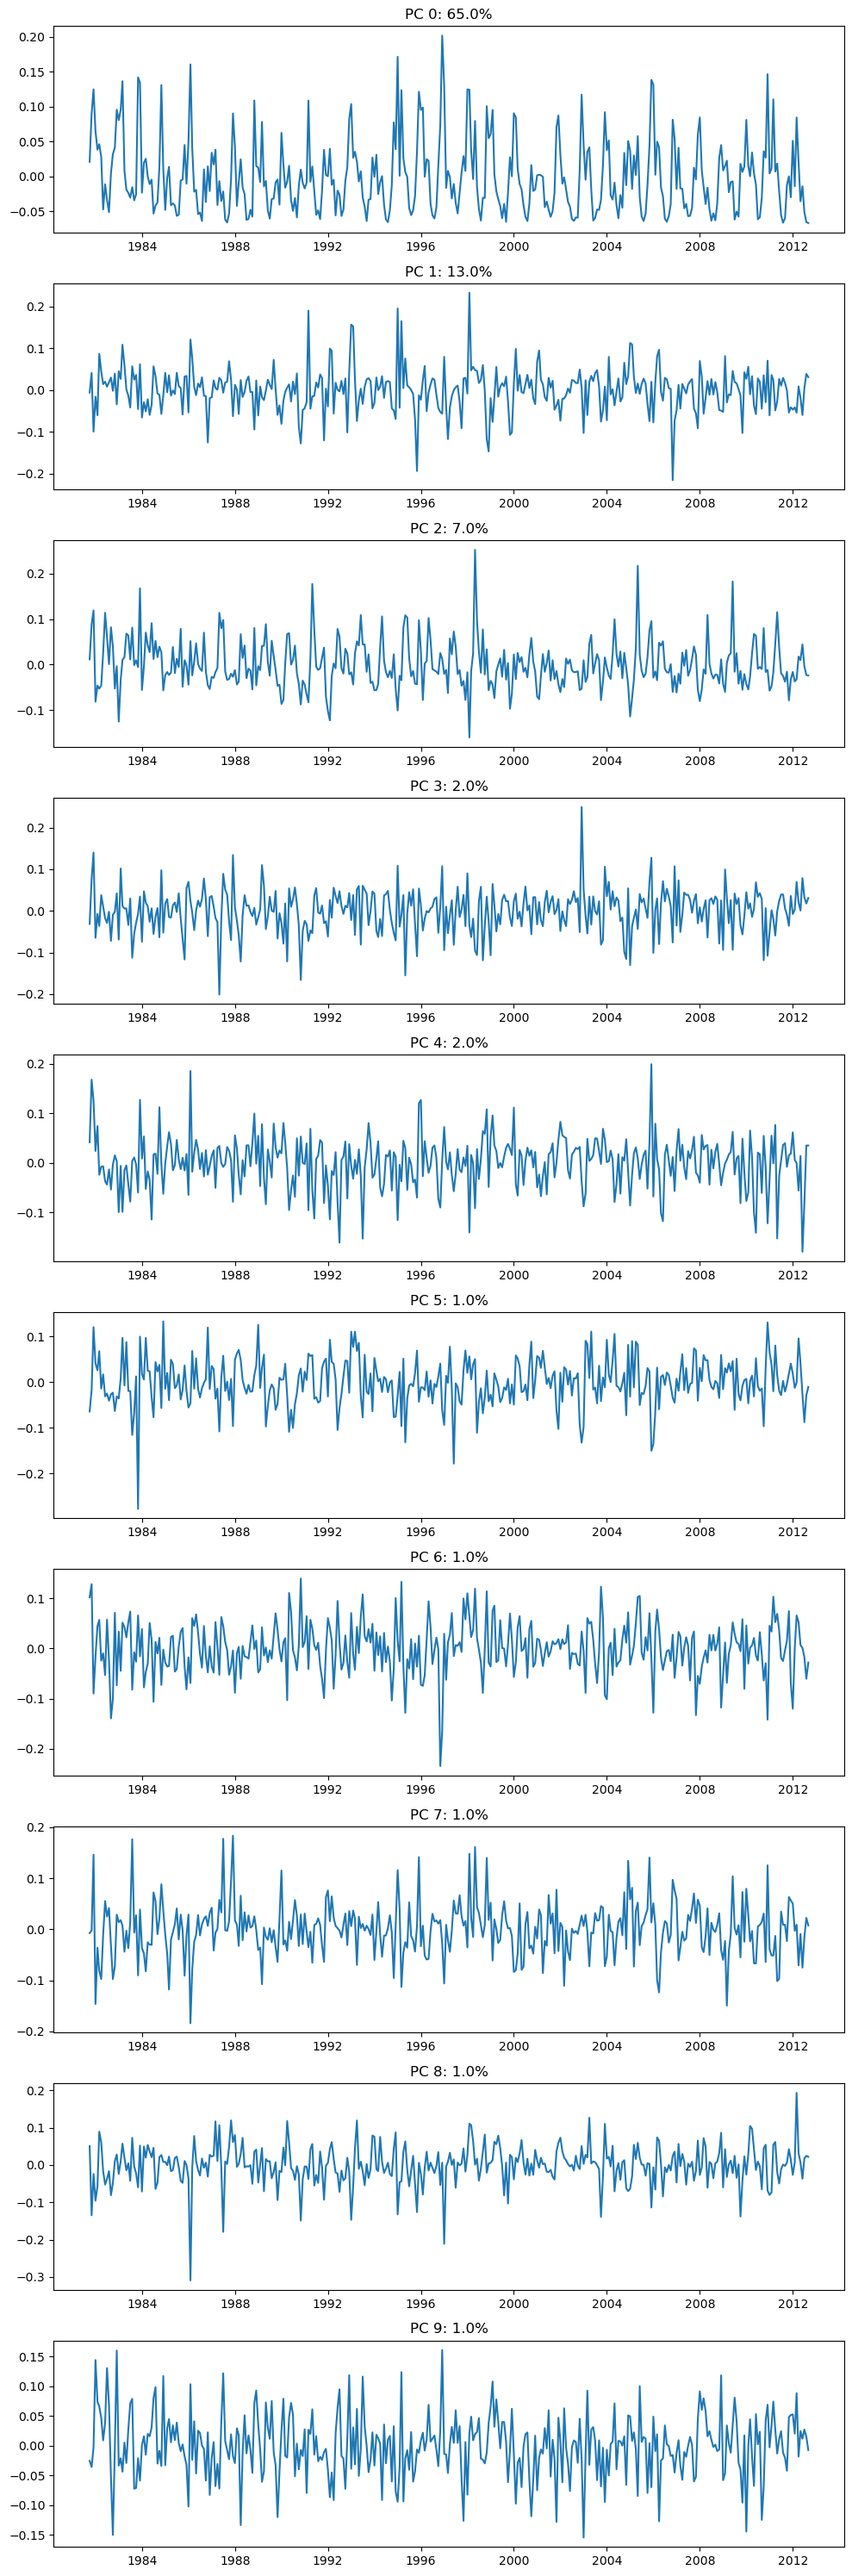

In [24]:
# Plot the 10 leading PCs
f, ax = plt.subplots(10,1,figsize=(10,30))
for i in range(10):
    ax[i].plot(dates,-1*V[i,:]); # with -1 multiplier
    ax[i].set_title('PC {}: {}%'.format(i,np.round(100*var_exp[i]),2));
plt.tight_layout()

---

#### Reconstructing Original Data

Reconstruct and plot October 1981 data with only 10 EOFs/PCs. 

We can reconstruct much of the original data using only the first several patterns. This requires much less information than the original data itself.

See documentation and examples [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html).

In [25]:
# Select the first 10 to reconstruct the precip data
i=9
ppt_reconstructed = np.dot(U[:,:i] * S[:i], V[:i,:])

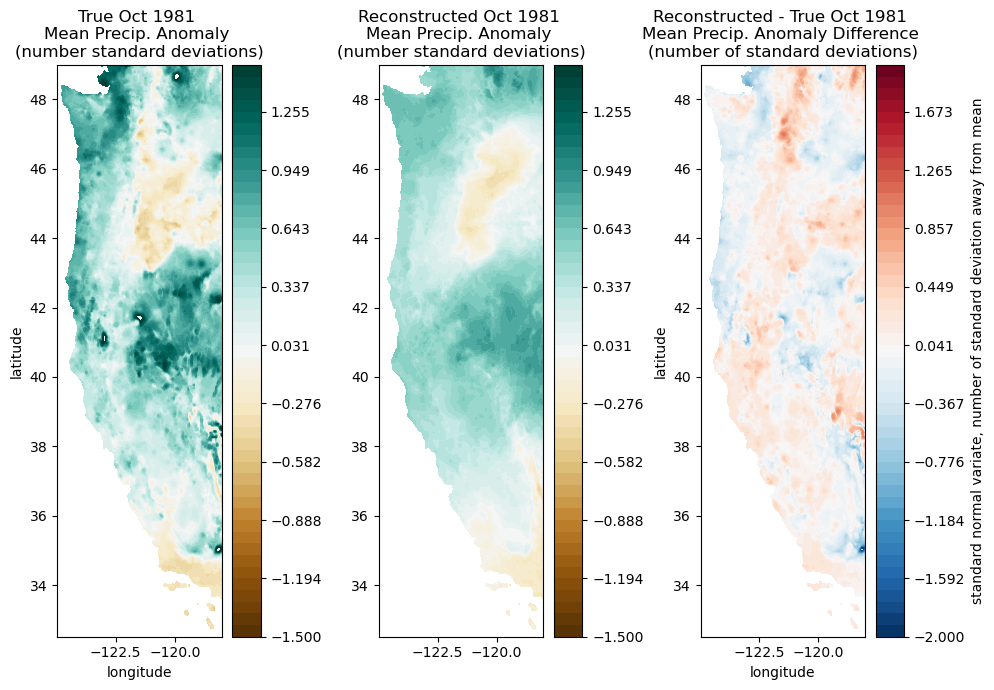

In [26]:
fig, ax = plt.subplots(1,3,figsize=(10,7))

month = 0

# Plot the original precip data
cf = ax[0].contourf(Xs,Ys,make_map(ppt[:,month], n, nx, ny), levels=np.linspace(-1.5,1.5), cmap='BrBG')
cbar = plt.colorbar(cf, ax=ax[0])
ax[0].set_title('True Oct 1981 \nMean Precip. Anomaly \n(number standard deviations)');
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

# Plot the reconstructed precip data
cf = ax[1].contourf(Xs,Ys,make_map(ppt_reconstructed[:,month], n, nx, ny), levels=np.linspace(-1.5,1.5), cmap='BrBG')
cbar = plt.colorbar(cf, ax=ax[1])
ax[1].set_title('Reconstructed Oct 1981 \nMean Precip. Anomaly \n(number standard deviations)');
plt.xlabel('longitude')
plt.ylabel('latitude')

# Plot the difference between the original and reconstructed data
difference = make_map(ppt_reconstructed[:,month], n, nx, ny) - make_map(ppt[:,month], n, nx, ny)
cf = ax[2].contourf(Xs,Ys,difference,levels=np.linspace(-2,2),cmap='RdBu_r')
cbar = plt.colorbar(cf, ax=ax[2])
cbar.ax.set_ylabel('standard normal variate, number of standard deviation away from mean')
ax[2].set_title('Reconstructed - True Oct 1981 \nMean Precip. Anomaly Difference \n(number of standard deviations)');
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.tight_layout()

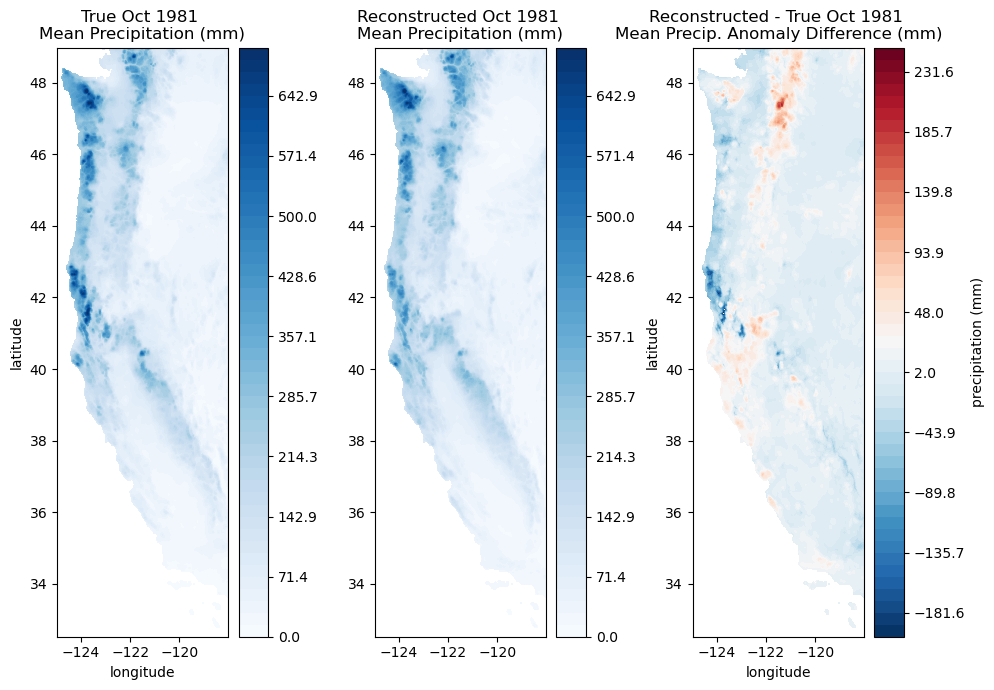

In [27]:
# And we can convert to actual mm of precipitation
fig, ax = plt.subplots(1,3,figsize=(10,7))

month = 0

# Plot the original precip data
cf = ax[0].contourf(Xs,Ys,ppt_mean + np.multiply(ppt_stdev,make_map(ppt[:,month], n, nx, ny)), levels=np.linspace(0,700), cmap='Blues')
cbar = plt.colorbar(cf, ax=ax[0])
ax[0].set_title('True Oct 1981 \nMean Precipitation (mm)');
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

# Plot the reconstructed precip data
cf = ax[1].contourf(Xs,Ys,ppt_mean + np.multiply(ppt_stdev,make_map(ppt_reconstructed[:,month], n, nx, ny)), levels=np.linspace(0,700), cmap='Blues')
cbar = plt.colorbar(cf, ax=ax[1])
ax[1].set_title('Reconstructed Oct 1981 \nMean Precipitation (mm)');
plt.xlabel('longitude')
plt.ylabel('latitude')

# Plot the difference between the original and reconstructed data
difference = np.multiply(ppt_stdev,make_map(ppt_reconstructed[:,month], n, nx, ny) - make_map(ppt[:,month], n, nx, ny))
cf = ax[2].contourf(Xs,Ys,difference,levels=np.linspace(-200,250),cmap='RdBu_r')
cbar = plt.colorbar(cf, ax=ax[2])
cbar.ax.set_ylabel('precipitation (mm)')
ax[2].set_title('Reconstructed - True Oct 1981 \nMean Precip. Anomaly Difference (mm)');
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.tight_layout()

You can compare these plots with the ones above in standard normal variate space and consider what is more useful.  It depends on your application.  The top one illustrates deviations from typical precipitation for both wet and dry regions, while the bottom one emphasizes wet regions. 